# Explore Training Curves

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy

sns.set()
sns.set_style("whitegrid")
%matplotlib inline
plt.rcParams["figure.figsize"] = (6,5)

In [3]:
def find_moving_avg(data, window_size):
    if data.shape[0] == 1:
        quantile1 = np.zeros(data.shape[1]-window_size)
        quantile2 = np.zeros(data.shape[1]-window_size)
        avg = np.zeros(data.shape[1]-window_size)
        for i in range(data.shape[1]-window_size):
            avg[i] = np.mean(data[0,i:i+window_size])
            quantile1[i] = np.quantile(data[0,i:i+window_size], 0.25)
            quantile2[i] = np.quantile(data[0,i:i+window_size], 0.75)
        return avg, quantile1, quantile2
    else:
        std = np.std(data,axis=0)
        avg = np.mean(data,axis=0)
        smoothed_avg = np.zeros(data.shape[1]-window_size)
        smoothed_std = np.zeros(data.shape[1]-window_size)
        # smooth 
        for i in range(data.shape[1]-window_size):
            smoothed_avg[i] = np.mean(avg[i:i+window_size])
            smoothed_std[i] = np.mean(std[i:i+window_size])
        return smoothed_avg, smoothed_avg-smoothed_std, smoothed_avg+smoothed_std
            

def df_plot(dfs, x, y, isTaxi, isChain, isCliff, ylim=None, xlim=None, legend_loc='best'):
    """ Plot y vs. x curves from pandas dataframe(s)

    Args:
        dfs: list of pandas dataframes
        x: str column label for x variable
        y: str column label for y variable
        ylim: tuple to override automatic y-axis limits
        xlim: tuple to override automatic x-axis limits
        legend_loc: str to override automatic legend placement:
            'upper left', 'lower left', 'lower right' , 'right' ,
            'center left', 'center right', 'lower center',
            'upper center', and 'center'
    """
    if ylim is not None:
        plt.ylim(ylim)
    if xlim is not None:
        plt.xlim(xlim)
        
    n = len(dfs)
    ws = 5
    if isTaxi == True:
        min_len = 84
        timesteps_per_eps = 70
        y_val = np.zeros((n,84))
        plt.title('Taxi', fontsize = 26)
    if isChain == True:
        min_len = 500
        timesteps_per_eps = 1000
        y_val = np.zeros((n,500))
        ws = 30
        plt.title('Chain', fontsize = 26)
    if isCliff == True:
        min_len = 1000
        y_val = np.zeros((n,1000))
        timesteps_per_eps = 50
        plt.title('Cliff', fontsize = 26)
    
    i = 0
    for df, name in dfs:
        if '_' in name:
            name = name.split('_')[1]
            if 'Wass' in name:
                name = 'ODRPO-Wass'
        x_val = df[x]
        y_val[i,:] = df[y].values.ravel()[0:min_len]
        i += 1
                
    moving_average = find_moving_avg(y_val, ws)
    plt.plot(x_val[0:len(moving_average[0])]*timesteps_per_eps/100000, moving_average[0], linewidth = 2.5, label=name, color = 'tab:orange')
    plt.fill_between(x_val[0:len(moving_average[0])]*timesteps_per_eps/100000, moving_average[1], moving_average[2], alpha=0.3, color = 'tab:orange')
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.axis((None,None,None,None))
    plt.xlabel('            Timesteps       '+ r'$\times 10^5$',fontsize=22)
    plt.ylabel('Average Return',fontsize=22)
    
    print(np.mean(moving_average[0][-5]))
    print(np.mean(moving_average[2][-5]) - np.mean(moving_average[0][-5]))

In [4]:
isTaxi = True
isChain = False
isCliff = False


# ENTER LIST OF LOG FILENAMES HERE:
if isTaxi:
    wass_path = ['archive_logs/Taxi-v3_DR-Wass_Batch=60/Feb-11_01:20:04/log.csv', 
                 'archive_logs/Taxi-v3_DR-Wass_Batch=60/Feb-22_01:40:39/log.csv']
if isChain:
    wass_path = ['new_log_files/accurate/NChain-v0_DR-Wass_Batch=1/Oct-19_07:58:22/log.csv',
                 'new_log_files/accurate/NChain-v0_DR-Wass_Batch=1/Oct-19_08:05:03/log.csv']
if isCliff:
    wass_path = ['archive_logs/CliffWalking-v0_DR-Wass_Batch=3/Feb-18_16:41:21/log.csv']

wass_dataframes = []
wass_names = []
for filepath in wass_path:
    wass_names.append(filepath.split('/')[1])
    wass_dataframes.append(pd.read_csv(filepath))
wass_data = list(zip(wass_dataframes, wass_names))

# Plots

In [5]:
def find_baseline_moving_avg(file_list, window_size):  
    if len(file_list) == 1:
        df=pd.read_csv(file_list[0], sep=',', skiprows = 0, header= 1)
        data = df['r']
        quantile1 = np.zeros(len(data)-window_size)
        quantile2 = np.zeros(len(data)-window_size)
        avg = np.zeros(len(data)-window_size)
        for i in range(len(data)-window_size):
            avg[i] = np.mean(data[i:i+window_size])
            quantile1[i] = np.quantile(data[i:i+window_size], 0.25)
            quantile2[i] = np.quantile(data[i:i+window_size], 0.75)
        return avg, quantile1, quantile2
    else:
        # find minimum length
        min_len = 1e7
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], sep=',', skiprows = 0, header= 1)
            y_val = df['r']
            cur_len = len(y_val)
            if cur_len < min_len:
                min_len = cur_len
        data = np.zeros((len(file_list), min_len))
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], sep=',', skiprows = 0, header= 1)
            data[i,:] = df['r'].values.ravel()[0:min_len]
        std = np.std(data,axis=0)
        avg = np.mean(data,axis=0)
        smoothed_avg = np.zeros(min_len-window_size)
        smoothed_std = np.zeros(min_len-window_size)
        # smooth 
        for i in range(min_len-window_size):
            smoothed_avg[i] = np.mean(avg[i:i+window_size])
            smoothed_std[i] = np.mean(std[i:i+window_size])
        return smoothed_avg, smoothed_avg-smoothed_std, smoothed_avg+smoothed_std

-63.3483335
8.1750003
TRPO
-200.63600000000002
1.2347877538268222
A2C
-303.88466666666665
26.814543255040405
PPO
-342.85733333333326
36.146080551868806


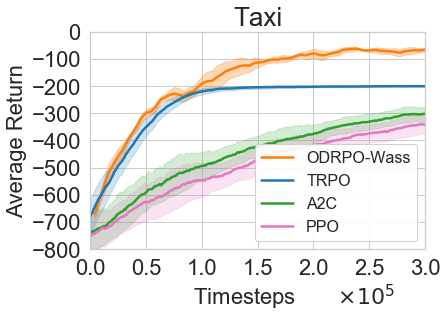

In [6]:
if isTaxi:
    xlim = 3
    df_plot(wass_data, '_Episode', ['_AvgRewardSum'], isTaxi, isChain, isCliff, [-800,0], [0,3.0])
    window_size = 30
if isChain:
    xlim = 6
    df_plot(wass_data, '_Episode', ['_AvgRewardSum'], isTaxi, isChain, isCliff, [1500,4000], [0,4.0])
    window_size = 30
if isCliff:
    xlim = 0.3
    df_plot(wass_data, '_Episode', ['_AvgRewardSum'], isTaxi, isChain, isCliff, [-3000,100], [0,0.3])
    window_size = 3
    
# read baseline results
if isTaxi:
    trpo_log_name = ['./tmp/trpo_taxi_monitor1.csv','./tmp/trpo_taxi_monitor2.csv','./tmp/trpo_taxi_monitor3.csv',
                    './tmp/trpo_taxi_monitor4.csv','./tmp/trpo_taxi_monitor5.csv']
    a2c_log_name = ['./tmp/a2c_taxi_monitor1.csv','./tmp/a2c_taxi_monitor2.csv','./tmp/a2c_taxi_monitor3.csv',
                   './tmp/a2c_taxi_monitor4.csv','./tmp/a2c_taxi_monitor5.csv']
    ppo_log_name = ['./tmp/ppo_taxi_monitor1.csv','./tmp/ppo_taxi_monitor2.csv','./tmp/ppo_taxi_monitor3.csv',
                   './tmp/ppo_taxi_monitor4.csv','./tmp/ppo_taxi_monitor5.csv']
    
if isChain:
    trpo_log_name = ['./tmp/trpo_chain_monitor1.csv','./tmp/trpo_chain_monitor2.csv',
                    './tmp/trpo_chain_monitor3.csv','./tmp/trpo_chain_monitor4.csv',
                    './tmp/trpo_chain_monitor5.csv']
    a2c_log_name = ['./tmp/a2c_chain_monitor1.csv','./tmp/a2c_chain_monitor2.csv']
    ppo_log_name = ['./tmp/ppo_chain_monitor1.csv','./tmp/ppo_chain_monitor2.csv',
                   './tmp/ppo_chain_monitor3.csv','./tmp/ppo_chain_monitor4.csv',
                   './tmp/ppo_chain_monitor5.csv']

if isCliff:
    trpo_log_name = ['./tmp/trpo_cliff_monitor1.csv','./tmp/trpo_cliff_monitor2.csv',
                    './tmp/trpo_cliff_monitor3.csv','./tmp/trpo_cliff_monitor4.csv',
                    './tmp/trpo_cliff_monitor5.csv']
    a2c_log_name = ['./tmp/a2c_cliff_monitor1.csv']
    ppo_log_name = ['./tmp/ppo_cliff_monitor1.csv', './tmp/ppo_cliff_monitor3.csv']
    window_size = 3
    

moving_average = find_baseline_moving_avg(trpo_log_name, window_size)
ts_per_iter = 1024
plt.plot(np.arange(len(moving_average[0]))*ts_per_iter/100000, moving_average[0], label='TRPO', linewidth = 2.5, color = 'tab:blue')
plt.fill_between(np.arange(len(moving_average[0]))*ts_per_iter/100000, moving_average[1], moving_average[2], alpha=0.2, color = 'tab:blue')
print('TRPO')
print(np.mean(moving_average[0][int(xlim*100000/ts_per_iter-10): int(xlim*100000/ts_per_iter)]))
print(np.mean(moving_average[2][int(xlim*100000/ts_per_iter-10): int(xlim*100000/ts_per_iter)]) - np.mean(moving_average[0][int(xlim*100000/ts_per_iter-10): int(xlim*100000/ts_per_iter)]))

moving_average = find_baseline_moving_avg(a2c_log_name, window_size)
ts_per_iter = 1024
plt.plot(np.arange(len(moving_average[0]))*ts_per_iter/100000, moving_average[0], label='A2C', linewidth = 2.5, color = 'tab:green')
plt.fill_between(np.arange(len(moving_average[0]))*ts_per_iter/100000, moving_average[1], moving_average[2], alpha=0.2, color = 'tab:green')
print('A2C')
print(np.mean(moving_average[0][int(xlim*100000/ts_per_iter-10): int(xlim*100000/ts_per_iter)]))
print(np.mean(moving_average[2][int(xlim*100000/ts_per_iter-10): int(xlim*100000/ts_per_iter)]) - np.mean(moving_average[0][int(xlim*100000/ts_per_iter-10): int(xlim*100000/ts_per_iter)]))

moving_average = find_baseline_moving_avg(ppo_log_name, window_size)
ts_per_iter = 1024
plt.plot(np.arange(len(moving_average[0]))*ts_per_iter/100000, moving_average[0], label='PPO', linewidth = 2.5, color = 'tab:pink')
plt.fill_between(np.arange(len(moving_average[0]))*ts_per_iter/100000, moving_average[1], moving_average[2], alpha=0.2, color = 'tab:pink')
print('PPO')
print(np.mean(moving_average[0][int(xlim*100000/ts_per_iter-10): int(xlim*100000/ts_per_iter)]))
print(np.mean(moving_average[2][int(xlim*100000/ts_per_iter-10): int(xlim*100000/ts_per_iter)]) - np.mean(moving_average[0][int(xlim*100000/ts_per_iter-10): int(xlim*100000/ts_per_iter)]))


if isTaxi:
    plt.rcParams["legend.framealpha"] = 0.9
    plt.legend(fontsize=16, loc='lower right')

2.5
0.9729550745276564
0.5
0.9729550745276566


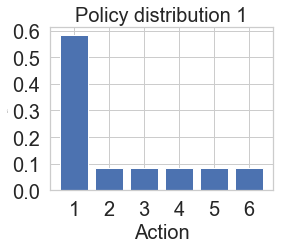

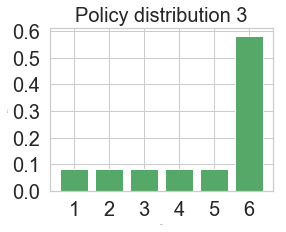

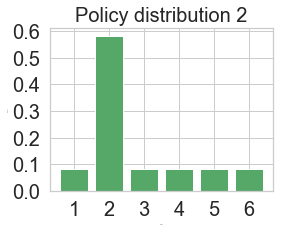

In [20]:
# define samples this way as scipy.stats.wasserstein_distance can't take probability distributions directly
sampP = [1,1,1,1,1,1,1,2,3,4,5,6]
sampQ = [1,2,3,4,5,6,6,6,6,6,6,6]
# and for scipy.stats.entropy (gives KL divergence here) we want distributions
P = np.unique(sampP, return_counts=True)[1] / len(sampP)
Q = np.unique(sampQ, return_counts=True)[1] / len(sampQ)
# compare to this sample / distribution:
sampQ2 = [1,2,2,2,2,2,2,2,3,4,5,6]
Q2 = np.unique(sampQ2, return_counts=True)[1] / len(sampQ2)


plt.rcParams["figure.figsize"] = (4,3)
plt.figure()
plt.bar(np.arange(len(P)), P, color='b')
plt.xticks(np.arange(len(P)), np.arange(1,7), fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Probability', fontsize = 0)
plt.xlabel('Action', fontsize = 20)
plt.title('Policy distribution 1', fontsize = 20)
plt.figure()
plt.bar(np.arange(len(Q)), Q, color='g')
plt.xticks(np.arange(len(Q)), np.arange(1,7), size = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Probability', fontsize = 0)
plt.xlabel('Action', fontsize = 0)
plt.title('Policy distribution 3', fontsize = 20)
plt.figure()
plt.bar(np.arange(len(Q2)), Q2, color='g')
plt.xticks(np.arange(len(Q2)), np.arange(1,7), fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Probability', fontsize = 0)
plt.xlabel('Action', fontsize = 0)
plt.title('Policy distribution 2', fontsize = 20)
print(scipy.stats.wasserstein_distance(sampP, sampQ)) 
print(scipy.stats.entropy(P, Q))
print(scipy.stats.wasserstein_distance(sampP, sampQ2)) 
print(scipy.stats.entropy(P, Q2))
plt.show()